In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np

from joblib import Parallel, delayed

from scipy.cluster.hierarchy import fclusterdata

import matplotlib.pyplot as plt
%matplotlib inline

from utilities2015 import *

import os, sys
import time

In [2]:
dm = DataManager(data_dir=os.environ['GORDON_DATA_DIR'],
                 repo_dir=os.environ['GORDON_REPO_DIR'],
                 result_dir=os.environ['GORDON_RESULT_DIR'],
                 stack='MD593', section=117, segm_params_id='gridsize200')

textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1

In [3]:
window_size = 201
window_halfsize = (window_size-1)/2

In [4]:
sys.stderr.write('computing histogram for each pixel\n')
t = time.time()

single_channel_maps = [textonmap[dm.ymin-window_halfsize : dm.ymax+1+window_halfsize, 
                                 dm.xmin-window_halfsize : dm.xmax+1+window_halfsize] == c
                       for c in range(n_texton)]

from skimage.transform import integral_image

# it is important to pad the integral image with zeros before first row and first column
def compute_integral_image(m):
    return np.pad(integral_image(m), ((1,0),(1,0)), mode='constant', constant_values=0)

int_imgs = np.dstack(Parallel(n_jobs=4)(delayed(compute_integral_image)(m) for m in single_channel_maps))

sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))

34.5962970257


In [5]:
histograms = int_imgs[window_size:, window_size:] + \
            int_imgs[:-window_size, :-window_size] - \
            int_imgs[window_size:, :-window_size] - \
            int_imgs[:-window_size, window_size:]
        
histograms_normalized = histograms/histograms.sum(axis=-1)[...,None].astype(np.float)

In [10]:
dm._load_image(versions=['rgb-jpg'])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (203470848 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


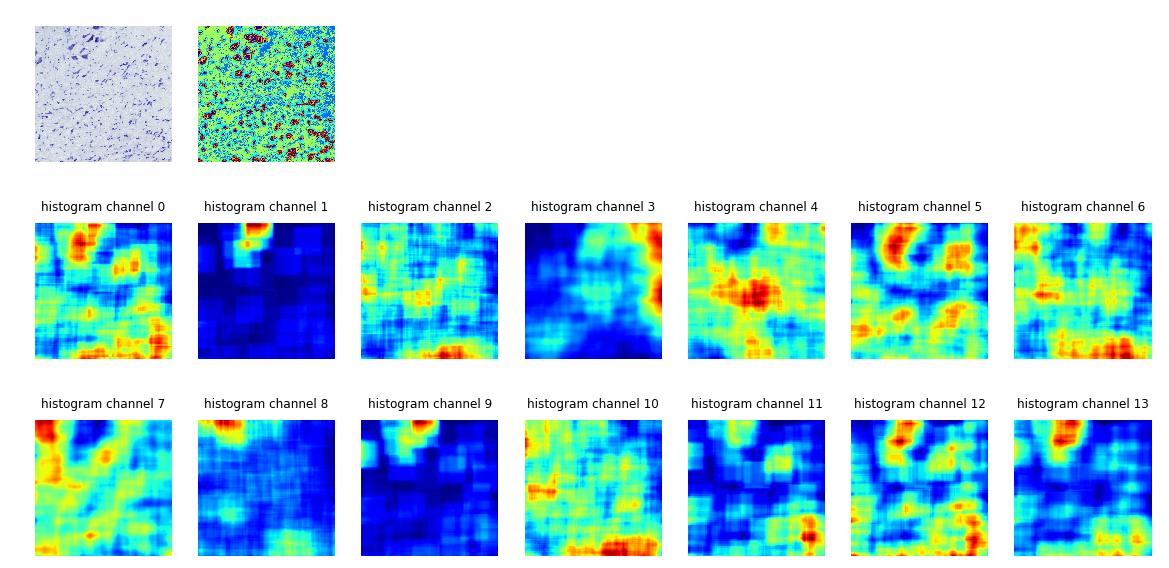

In [17]:
fig, axes = plt.subplots(3,7,figsize=(20,10));
for ax in axes.flat:
    ax.axis('off');
    
axes[0,0].imshow(dm.image_rgb_jpg[dm.ymin:dm.ymin+1000, dm.xmin:dm.xmin+1000]);
axes[0,1].imshow(textonmap[dm.ymin:dm.ymin+1000, dm.xmin:dm.xmin+1000]);
for i in range(n_texton):
    axes[1+i/7, i%7].matshow(histograms_normalized[:1000, :1000, i]);
    axes[1+i/7, i%7].set_title('histogram channel %d' % i);

In [15]:
from itertools import chain
from operator import itemgetter

# w_spatial = 0.001

# spacing = 200
# sp_ys, sp_xs = np.mgrid[0:dm.h:spacing, 0:dm.w:spacing]
# sp_texhists = histograms_normalized[sp_ys.flat, sp_xs.flat]
# centroids = np.c_[sp_xs.flat, sp_ys.flat, sp_texhists]
# n_superpixels = centroids.shape[0]

In [16]:
def compute_distance_to_centroids(centroids, spacing, w_spatial, hist_map, h, w):
    ds = [None for _ in range(centroids.shape[0])]
    
    for centroid_ind, centroid in enumerate(centroids):
        cx = int(centroid[0])
        cy = int(centroid[1])
        ch = centroid[2:]

        ymin = max(0, cy - 2*spacing)
        xmin = max(0, cx - 2*spacing)
        ymax = min(h-1, cy + 2*spacing)
        xmax = min(w-1, cx + 2*spacing)

        ys, xs = np.mgrid[ymin:ymax+1, xmin:xmax+1].astype(np.int)
        spatial_ds = np.squeeze(cdist([[cx, cy]], np.c_[xs.flat, ys.flat], 'euclidean'))

        texture_ds = chi2s([ch], hist_map[ys.flat, xs.flat])
        ds[centroid_ind] = w_spatial * spatial_ds + texture_ds

    return ds

def compute_new_centroids(sps, assignments, hist_map):
    centroids = [None for _ in range(len(sps))]
    for i, sp_i in enumerate(sps):
        rs, cs = np.where(assignments == sp_i)
        centroids[i] = np.r_[np.c_[rs, cs].mean(axis=0)[::-1], hist_map[rs, cs].mean(axis=0)]
    return centroids

In [17]:
def slic_texture(hist_map, spacing=200, w_spatial=0.001, max_iter=5):

#     hist_map = histograms_normalized
#     spacing=200
#     w_spatial=0.001
#     max_iter=1

    h, w = hist_map.shape[:2]

    from itertools import chain
    from operator import itemgetter

    sp_ys, sp_xs = np.mgrid[0:h:spacing, 0:w:spacing]
    sp_texhists = hist_map[sp_ys.flat, sp_xs.flat]
    centroids = np.c_[sp_xs.flat, sp_ys.flat, sp_texhists]
    n_superpixels = centroids.shape[0]

    for iter_i in range(max_iter):

        print 'iteration', iter_i

        assignments = -1 * np.ones((h, w), np.int16)
        distances = np.inf * np.ones((h, w), np.float16)

        sys.stderr.write('compute_distance_to_centroids\n')
        t = time.time()

        for i in range(0, n_superpixels, 500):

            res = Parallel(n_jobs=16)(delayed(compute_distance_to_centroids)(centroids_p, 
                                                                             spacing=spacing,
                                                                            w_spatial=w_spatial,
                                                                            hist_map=hist_map,
                                                                             h=h, w=w)
                                      for centroids_p in np.array_split(centroids[i:i+500], 16))

            new_dists = list(chain(*res))

            for sp_i, nds in enumerate(new_dists):

                cx = int(centroids[i+sp_i, 0])
                cy = int(centroids[i+sp_i, 1])

                ymin = max(0, cy - 2*spacing)
                xmin = max(0, cx - 2*spacing)
                ymax = min(h-1, cy + 2*spacing)
                xmax = min(w-1, cx + 2*spacing)

                ys, xs = np.mgrid[ymin:ymax+1, xmin:xmax+1].astype(np.int)
                cls = np.c_[ys.flat, xs.flat]

                s = nds < distances[cls[:,0], cls[:,1]]
                distances[cls[s,0], cls[s,1]] = nds[s]
                assignments[cls[s,0], cls[s,1]] = i + sp_i

            del res
            del new_dists

        sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))


        sys.stderr.write('update assignment\n')
        t = time.time()

        centroids_part = Parallel(n_jobs=16)(delayed(compute_new_centroids)(sps, assignments=assignments,
                                                                           hist_map=hist_map) 
                                             for sps in np.array_split(range(n_superpixels), 16))
        centroids_new = np.vstack(centroids_part)

        print 'total centroid location change', np.sum(np.abs(centroids_new[:,:2] - centroids[:,:2]))

        centroids = centroids_new

        sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))

    return assignments

In [18]:
assignments = slic_texture(histograms_normalized, max_iter=2)

iteration 0


compute_distance_to_centroids
done in 157.84 seconds
update assignment


total centroid location change 29902.1974804


done in 27.60 seconds


In [ ]:
for iter_i in range(1):

    print 'iteration', iter_i
    
    assignments = -1 * np.ones((dm.h, dm.w), np.int16)
    distances = np.inf * np.ones((dm.h, dm.w), np.float16)

#     t = time.time()
    
    for i in range(0, n_superpixels, 500):

        sys.stderr.write('compute_distance_to_centroids\n')
        t=  time.time()

        res = Parallel(n_jobs=16)(delayed(compute_distance_to_centroids)(centroids_p) 
                                  for centroids_p in np.array_split(centroids[i:i+500], 16))

        new_dists = list(chain(*res))
        
        sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))

        sys.stderr.write('update assignment\n')
        t=  time.time()
        
        for sp_i, nds in enumerate(new_dists):
            
            cx = int(centroids[i+sp_i, 0])
            cy = int(centroids[i+sp_i, 1])

            ymin = max(0, cy - 2*spacing)
            xmin = max(0, cx - 2*spacing)
            ymax = min(dm.h-1, cy + 2*spacing)
            xmax = min(dm.w-1, cx + 2*spacing)

            ys, xs = np.mgrid[ymin:ymax+1, xmin:xmax+1].astype(np.int)
            cls = np.c_[ys.flat, xs.flat]
            
            sys.stderr.write('update assignment\n')
            t1 = time.time()
            
            s = nds < distances[cls[:,0], cls[:,1]]

            distances[cls[s,0], cls[s,1]] = nds[s]

            sys.stderr.write('done in %.4f seconds\n' % (time.time() - t1))

            sys.stderr.write('update assignment\n')
            t2 = time.time()
            
            assignments[cls[s,0], cls[s,1]] = i + sp_i

            sys.stderr.write('done in %.4f seconds\n' % (time.time() - t2))
            
        del res
        del new_dists
        
        sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))

#     print time.time() - t

#     t = time.time()

#     centroids_part = Parallel(n_jobs=16)(delayed(compute_new_centroids)(sps) for sps in np.array_split(range(n_superpixels), 16))
#     centroids_new = np.vstack(centroids_part)

#     print 'total centroid location change', np.sum(np.abs(centroids_new[:,:2] - centroids[:,:2]))
    
#     centroids = centroids_new

#     print time.time() - t

In [60]:
dm._load_image(versions=['rgb-jpg'])

In [118]:
from skimage.segmentation import mark_boundaries
viz = mark_boundaries(dm.image_rgb_jpg[dm.ymin:dm.ymax+1, dm.xmin:dm.xmax+1], q, color=(1,0,0))
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg